In [1]:
import numpy as np
import datetime as dt
from scipy import signal
import matplotlib.pyplot as pl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
import numbers

In [2]:
delphi_inst = np.genfromtxt('delphi_inst.txt', delimiter=",", dtype=float)
ismr_phi_inst = np.genfromtxt('ismr_phi_inst.txt', delimiter=",", dtype=float)
nino_phi_inst = np.genfromtxt('nino3_phi_inst.txt', delimiter=",", dtype=float)
dvolc_years = np.genfromtxt('sigl_years.txt', delimiter=",", dtype=float).flatten()[::-1]
dvolc_gvf = np.genfromtxt('sigl_gvf.txt', delimiter=",", dtype=float).flatten()[::-1]
dvolc_source = np.genfromtxt('sigl_source.txt', delimiter=",", dtype=float).flatten()[::-1]

delphi_inst_grad = np.gradient(delphi_inst)
nino_phi_inst_grad = np.gradient(nino_phi_inst)
ismr_phi_inst_grad = np.gradient(ismr_phi_inst)

In [3]:
def common_time_axis(dismr, verbose=True):
    """
    Generates common time axis for Nino3 and ISMR time series.
    """
    # generate the time axis
    Nt = len(dismr)
    time = [dt.datetime(1871, 1, 15)]
    for i in range(1, len(dismr)):
        y = time[i - 1].year
        m = time[i - 1].month
        if m == 12:
            y += 1
            m = 0
        time.append(dt.datetime(y, m + 1, 15))
    time = np.array(time)

    return time

def yearly_time_axis(dvolc_years, verbose=True):
    """
    Generates time axis for yearly data 
    """
    Nt = len(dvolc_years)
    time = [dt.datetime(dvolc_years[0], 1, 15)]
    for i in range(1, len(dvolc_years)):
        time.append(dt.datetime(dvolc_years[i], 1, 15))
    time = np.array(time)

    return time

ct = common_time_axis(ismr_phi_inst)
volc_time = yearly_time_axis(dvolc_years.astype(int))

In [4]:
# Bootstrapping
win = 6
nino_phi_grad_volc = []
nino_phi_grad_novolc = []
ismr_phi_grad_volc = []
ismr_phi_grad_novolc = []

for i in range(ct.shape[0]):
    for j in range(i,volc_time.shape[0]):
        cut_dt = dt.datetime(volc_time[j].year + win, volc_time[j].month, volc_time[j].day)
        if ct[i] > volc_time[j] and ct[i] < cut_dt:
            nino_phi_grad_volc.append(nino_phi_inst_grad[i])
            ismr_phi_grad_volc.append(ismr_phi_inst_grad[i])
        else:
            nino_phi_grad_novolc.append(nino_phi_inst_grad[i])
            ismr_phi_grad_novolc.append(ismr_phi_inst_grad[i])

In [5]:
from scipy import stats
nino_phi_grad_volc = np.asarray(nino_phi_grad_volc).flatten()
nino_phi_grad_novolc = np.asarray(nino_phi_grad_novolc).flatten()
print(stats.ks_2samp(nino_phi_grad_volc, nino_phi_grad_novolc))

Ks_2sampResult(statistic=0.3564902137060998, pvalue=3.2781180631488126e-16)


In [6]:
from scipy import stats
ismr_phi_grad_volc = np.asarray(ismr_phi_grad_volc).flatten()
ismr_phi_grad_novolc = np.asarray(ismr_phi_grad_novolc).flatten()
print(stats.ks_2samp(ismr_phi_grad_volc, ismr_phi_grad_novolc))

Ks_2sampResult(statistic=0.16966483926504372, pvalue=0.0005314578150323228)


In [7]:
def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False, rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.
    Parameters
    ----------
    x, y : array-like
    One-dimensional numeric arrays.
    ax : matplotlib.axes.Axes, optional
    Axes on which to plot. If not provided, the current axes will be used.
    quantiles : int or array-like, optional
    Quantiles to include in the plot. This can be an array of quantiles, in
    which case only the specified quantiles of `x` and `y` will be plotted.
    If this is an int `n`, then the quantiles will be `n` evenly spaced
    points between 0 and 1. If this is None, then `min(len(x), len(y))`
    evenly spaced quantiles between 0 and 1 will be computed.
    interpolation : {linear, lower, higher, midpoint, nearest}
    Specify the interpolation method used to find quantiles when `quantiles`
    is an int or None. See the documentation for numpy.quantile().
    rug : bool, optional
    If True, draw a rug plot representing both samples on the horizontal and
    vertical axes. If False, no rug plot is drawn.
    rug_length : float in [0, 1], optional
    Specifies the length of the rug plot lines as a fraction of the total
    vertical or horizontal length.
    rug_kwargs : dict of keyword arguments
    Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
    matplotlib.axes.Axes.axhline() when drawing rug plots.
    kwargs : dict of keyword arguments
    Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
    the q-q plot.
    """
# Get current axes if none are provided
    if ax is None:
        ax = plt.gca()
    if quantiles is None:
        quantiles = min(len(x), len(y))
# Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, interpolation=interpolation)
    y_quantiles = np.quantile(y, quantiles, interpolation=interpolation)
# Draw the rug plots if requested
    if rug:
# Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)
# Override default setting by any user-specified settings
    if rug_kwargs is not None:
        rug_x_params.update(rug_kwargs)
        rug_y_params.update(rug_kwargs)
# Draw the rug plots
    for point in x:
        ax.axvline(point, **rug_x_params)
    for point in y:
        ax.axhline(point, **rug_y_params)
# Draw the q-q plot

    ax.scatter(x_quantiles, y_quantiles, **kwargs)
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color='k')

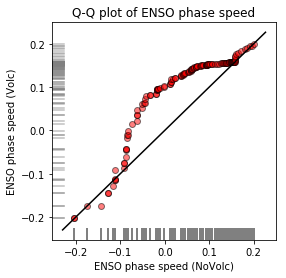

In [21]:
plt.figure(figsize=(4,4))
qqplot(nino_phi_grad_novolc, nino_phi_grad_volc, c='r', alpha=0.5, edgecolor='k', rug=True)
plt.xlabel('ENSO phase speed (NoVolc)')
plt.ylabel('ENSO phase speed (Volc)')
plt.title('Q-Q plot of ENSO phase speed')
abline(1,0)
plt.show()
plt.close()

<Figure size 288x288 with 0 Axes>

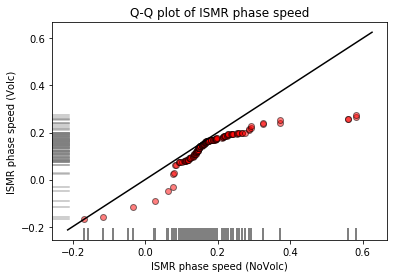

In [22]:
# Draw quantile-quantile plot with rug plot
plt.figure(figsize=(4,4))
plt.figure()
qqplot(ismr_phi_grad_novolc, ismr_phi_grad_volc, c='r', alpha=0.5, edgecolor='k', rug=True)
plt.xlabel('ISMR phase speed (NoVolc)')
plt.ylabel('ISMR phase speed (Volc)')
plt.title('Q-Q plot of ISMR phase speed')
abline(1,0)
plt.show()
plt.close()